**`Dependencies`**

In [1]:
%%bash
python -V
pip install -U pip pmdarima -q

Python 3.10.12


In [2]:
import os
import random

from datetime import datetime, timedelta
from typing import Any, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, pacf
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

**`Key Functions`**

In [5]:
def get_timestamps(path: str) -> List[str]:
    """
    Returns a list of string-formatted timestamps

    Args:
        path: File path that points to the raw time series data

    Returns:
        timestamps: List of string-formatted timestamps
    """
    raw_data: pd.DataFrame = pd.read_csv(path)
    min_timestamp: str = str(pd.to_datetime(raw_data["Datetime"]).min())
    max_timestamp: str = str(pd.to_datetime(raw_data["Datetime"]).max() - timedelta(days=8))
    timestamps: List[str] = [
        str(ts)
        for ts in pd.date_range(min_timestamp, max_timestamp, freq="H")
    ]
    return timestamps


def ensure_stationarity(data: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    Returns a DataFrame that contains a 1-D stationary time series

    Args:
        data: DataFrame that contains a univariate time series
        target: Column name of the univariate time series

    Returns:
        'data' if its univariate time series is stationary else
        'stationary_data'.  Note, 'stationary_data' contains two
        additional columns, 'prev' and 'diff', where 'prev' contains
        the once-lagged values of the original univariate time series,
        and 'diff' contains the once-differenced values of the original
        univariate time series.
    """
    p_value: float = adfuller(data[target].dropna())[1]
    stationary_data: pd.DataFrame = (
        data
        .assign(
            prev=data[target].shift(periods=1),
            diff=data[target].diff(periods=1)
        )
        .copy(deep=True)
    )
    return data if p_value < 0.05 else stationary_data


def create_lag_features(data: pd.DataFrame, target: str, p: int) -> pd.DataFrame:
    """
    Creates a matrix of lag features from a univariate time series

    Args:
        data: DataFrame that contains a univariate time series of length T
        target: Column name of the univariate time series
        p: Number of lag features to create

    Returns:
        df: Matrix of shape (T - p, p), that contains lag features
    """
    series: pd.Series = data[target].dropna()
    lags: List[pd.Series] = [series.shift(periods=i) for i in reversed(range(1, p + 1))]
    cols: List[str] = [f"lag_{i}" for i in reversed(range(1, p + 1))]
    df: pd.DataFrame = pd.concat(lags, axis=1).dropna()
    df.columns = cols
    return df


def create_window_features(
        data: pd.DataFrame,
        target: str,
        max_window_size: int
) -> pd.DataFrame:
    """
    Creates a matrix of window features from a univariate time series

    Args:
        data: DataFrame that contains a univariate time series
        target: Column name of the univariate time series
        max_window_size: Maximum number of lags that are used to
        create the window features

    Returns:
        DataFrame that contains window features
    """
    window_sizes: List[int] = np.arange(4, max_window_size + 1, 4).tolist()
    cols: List[List[str]] = [
        [f"mean_window_{window_size}", f"std_window_{window_size}"]
        for window_size in window_sizes
    ]
    cols: List[str] = np.array(cols).ravel().tolist()
    dfs: List[pd.DataFrame] = [
        (
            data[target]
            .dropna()
            .rolling(window=window_size, min_periods=1)
            .agg(["mean", "std"])
            .shift(periods=1)
        )
        for window_size in window_sizes
    ]
    df: pd.DataFrame = pd.concat(dfs, axis=1, ignore_index=True)
    df.columns = cols
    return df


def create_datetime_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a matrix of datetime features based on a time series index

    Args:
        data: DataFrame that contains a Pandas Datetime Index

    Returns:
        df: DataFrame that contains datetime features
    """
    hour_freq_cols: List[str] = ["hour", "time_of_day"]
    df: pd.DataFrame = pd.DataFrame(index=data.dropna().index)
    df = (
        df
        .assign(
            week=df.index.week,
            day_of_year=df.index.dayofyear,
            day_of_month=df.index.day,
            day_of_week=[idx + 1 for idx in df.index.dayofweek],
            hour=df.index.hour,
            time_of_day=[
                1 if x in range(5, 12)
                else 2 if x in range(12, 17)
                else 3 if x in range(17, 21)
                else 4 for x in df.index.hour
            ]
        )
    )
    return df if df.index.freq == "D" else df[hour_freq_cols]


def create_model_inputs(
        stationary_data: pd.DataFrame,
        target: str,
        p: int,
        max_window_size: int
) -> pd.DataFrame:
    """
    Converts a stationary univariate time series to a matrix of
    datetime features, window features, lag features, and the target

    Args:
        stationary_data: DataFrame that contains the in-sample stationary
        univariate time series
        target: Column name of the in-sample stationary univariate time series
        p: Number of lag features to create
        max_window_size: Maximum number of lags to use to create window features

    Returns:
        model_inputs: DataFrame that contains datetime features, window
        features, lag features, and the corresponding target
    """
    # create a matrix of lag features
    lag_data: pd.DataFrame = create_lag_features(stationary_data, target, p)

    # create a matrix of window features
    window_data: pd.DataFrame = create_window_features(
        stationary_data,
        target,
        max_window_size
    )

    # create a matrix of datetime features
    dt_data: pd.DataFrame = create_datetime_features(stationary_data)

    # create a 2-D matrix that contains all the features
    model_inputs: pd.DataFrame = pd.concat([dt_data, window_data, lag_data], axis=1).dropna()

    # add the target to the 'model_inputs' DataFrame
    model_inputs[target] = stationary_data.loc[model_inputs.index, target]
    return model_inputs


def get_recursive_forecast(
        stationary_data: pd.DataFrame,
        model: XGBRegressor,
        train_test_sets: Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]
) -> pd.Series:
    """
    Generates a recursive forecast

    Args:
        stationary_data: DataFrame that contains the in-sample stationary
        univariate time series
        model: Object of type, 'XGBRegressor'
        train_test_sets: Tuple that contains the train set feature matrix,
        train set target vector, test set feature matrix, and test set target
        vector

    Returns:
        Recursive forecast
    """
    # get the train and test sets
    Xtrain, ytrain, Xtest, ytest = train_test_sets

    # specify the lag features, window_features, datetime features, and target
    lag_cols: List[str] = [col for col in Xtrain.columns if "lag" in col]
    window_cols: List[str] = [col for col in Xtrain.columns if "window" in col]
    dt_cols: List[str] = [
        col
        for col in Xtrain.columns
        if col not in lag_cols + window_cols
    ]
    target: str = ytrain.name

    # fit and evaluate the model
    model.early_stopping_rounds = 10 if model.n_estimators == 100 else 50
    model.fit(
        Xtrain.values,
        ytrain.values,
        eval_set=[(Xtrain.values, ytrain.values), (Xtest.values, ytest.values)],
        verbose=10 if model.n_estimators == 100 else 50
    )

    # create a list of lists, ...
    # where each list is a row of values that correspond to the test set's datetime features
    x_dts: List[List[int]] = Xtest[dt_cols].values.tolist()

    # create a list of window sizes, ...
    # which will be used to compute values for the test set's window features
    window_sizes: List[int] = sorted(set(int(col.split("_")[-1]) for col in window_cols))
    dynamic_window: List[float] = ytrain.iloc[-max(window_sizes):].tolist()

    # create the 1st input
    x_dt: List[int] = x_dts[0]
    x_window: List[List[float]] = [
        [np.mean(dynamic_window[-window_size:]), np.std(dynamic_window[-window_size:])]
        for window_size in window_sizes
    ]
    x_window: List[float] = np.array(x_window).ravel().tolist()
    x_lag: List[float] = Xtrain.iloc[-1][lag_cols].tolist()
    x_lag = x_lag[1:] + [ytrain.iloc[-1]]
    x: np.ndarray = np.array(x_dt + x_window + x_lag)

    # get the 1st prediction and add it to a list named, 'forecast'
    yhat: float = model.predict(x.reshape(1, -1))[0]
    forecast: List[float] = [yhat]

    for x_dt in x_dts[1:]:

        # update the input
        dynamic_window: List[float] = dynamic_window[1:] + [yhat]
        x_window: List[List[float]] = [
            [np.mean(dynamic_window[-window_size:]), np.std(dynamic_window[-window_size:])]
            for window_size in window_sizes
        ]
        x_window: List[float] = np.array(x_window).ravel().tolist()
        x_lag: List[float] = x_lag[1:] + [yhat]
        x: np.ndarray = np.array(x_dt + x_window + x_lag)

        # get the prediction and append it to the 'forecast' list
        yhat: float = model.predict(x.reshape(1, -1))[0]
        forecast.append(yhat)

    # update the forecast if the target is a once-differenced time series
    forecast: np.array = (
        stationary_data.loc[Xtrain.index[-1], "prev"] + np.cumsum(forecast)
        if target == "diff"
        else np.array(forecast)
    )
    return pd.Series(forecast, index=Xtest.index)


def walk_forward_validation(
        stationary_data: pd.DataFrame,
        target: str,
        max_lag: int,
        max_window_size: int,
        forecast_horizon: int
) -> pd.DataFrame:
    """
    Performs time series cross-validation and returns the corresponding metrics
    and model

    Args:
        stationary_data: DataFrame that contains the in-sample stationary univariate
        time series
        target: Column name of the in-sample stationary univariate time series
        max_lag: Maximum number of lags to use to create lag features
        max_window_size: Maximum number of lags to use to create window features
        forecast_horizon: Number of time steps to forecast into the future

    Returns:
        model: Object of type, 'XGBRegressor'
        forecast_metrics: DataFrame of shape (N, K) that contains cross-validation
        metrics, where N is the number of lags and K is the number of folds
    """
    # instantiate an object of type, 'XGBRegressor'
    model: XGBRegressor = XGBRegressor(
        objective="reg:squarederror",
        booster="gbtree",
        base_score=0.5, 
        n_estimators=1000,
        min_child_weight=15
    )

    # get the total number of records (train and validation sets)
    N: int = create_model_inputs(stationary_data, target, max_lag, max_window_size).shape[0]

    # get the ending index of each fold's train set
    train_indices: List[int] = [N + (i*forecast_horizon) for i in np.arange(-10, 0)]

    # get the ending index of each fold's validation set
    val_indices: List[int] = [idx + forecast_horizon for idx in train_indices]

    # create a list of tuples, ...
    # where each tuple contains a pair of indices, ...
    # where the 1st index is the end of each fold's train set, and ...
    # the 2nd index is the end of each fold's validation set
    index_pairs: List[Tuple[int]] = [
        idx_pair
        for idx_pair in list(zip(train_indices, val_indices))
        if idx_pair[0] > 0
    ]

    # set the number of folds
    n_folds: int = len(index_pairs)

    # an empty dictionary to map each lag to its corresponding metrics
    forecast_metrics: Dict[int, List[float]] = {}

    for p in range(1, max_lag + 1):

        # create the model inputs
        df: pd.DataFrame = create_model_inputs(stationary_data, target, p, max_window_size)

        # extract the feature matrix
        X: pd.DataFrame = df.drop(target, axis=1).copy(deep=True)

        # get the corresponding target vector
        y: pd.Series = df[target].copy(deep=True)

        # an empty list to store each fold's validation set R²
        fold_metrics: List[float] = []

        for train_idx, val_idx in index_pairs:

            # split the feature matrix and target vector into train and validation sets
            X_train: pd.DataFrame = X.iloc[:train_idx, :]
            y_train: pd.Series = y.iloc[:train_idx]
            X_val: pd.DataFrame = X.iloc[train_idx:val_idx, :]
            y_val: pd.Series = y.iloc[train_idx:val_idx]

            # get the validation set's forecast
            forecast: pd.Series = get_recursive_forecast(
                stationary_data,
                model,
                (X_train, y_train, X_val, y_val)
            )

            # compute the validation set's R² and add it to the 'fold_metrics' list
            original_target: str = stationary_data.columns[0] if target == "diff" else target
            val_metric: float = get_rsquared(
                stationary_data.loc[X_val.index, original_target],
                forecast
            )
            fold_metrics.append(val_metric)

        # map the lag to its corresponding metrics, that is, ...
        # each lag will be mapped to K validation set R² values ...
        # where K is the number of folds
        forecast_metrics[p] = fold_metrics

    # cast the 'forecast_metrics' dictionary to a DataFrame
    forecast_metrics: pd.DataFrame = (
        pd.DataFrame
        .from_dict(
            forecast_metrics,
            orient="index",
            columns=[f"fold_{k + 1}" for k in range(n_folds)]
        )
        .rename_axis("n_lags")
    )

    return model, forecast_metrics


def predict_future(
        model: XGBRegressor,
        current_data: pd.DataFrame,
        relevant_features: List[str],
        target: str,
        max_lag: int,
        max_window_size: int,
        future_timestamps: pd.DatetimeIndex,
) -> np.ndarray:
    """
    Generates a recursive/multi-step forecast for 'out-of-sample' data

    Args:
        model: Object of type, 'XGBRegressor'
        current_data: DataFrame that contains the in-sample stationary univariate
        time series
        target: Column name of the in-sample stationary univariate time series
        max_lag: Maximum number of lags used to create lag features
        max_window_size: Maximum number of lags used to create window features
        future_timestamps: Pandas DateTime Index that contains the out-of-sample
        timestamps

    Returns:
        forecast: Recursive forecast
    """
    # create the model inputs
    model_inputs: pd.DataFrame = create_model_inputs(
        current_data,
        target,
        max_lag,
        max_window_size
    )

    # get the 'relevant' lag features and the column index of each
    lag_cols: List[str] = [col for col in model_inputs.columns if "lag" in col]
    rel_lag_cols: List[str] = [col for col in lag_cols if col in relevant_features]
    lag_col_idx: List[int] = [lag_cols.index(col) for col in rel_lag_cols]

    # get the 'relevant' window features and the column index of each
    window_cols: List[str] = [col for col in model_inputs.columns if "window" in col]
    rel_window_cols: List[str] = [col for col in window_cols if col in relevant_features]
    window_col_idx: List[int] = [window_cols.index(col) for col in rel_window_cols]

    # get the 'relevant' datetime features
    dt_cols: List[str] = [
        col
        for col in model_inputs.drop(target, axis=1).columns
        if (col in relevant_features) and (col not in lag_cols + window_cols)
    ]

    # extract the feature matrix
    X: pd.DataFrame = model_inputs[relevant_features].copy(deep=True)

    # get the corresponding target vector
    y: pd.Series = model_inputs[target].copy(deep=True)

    # fit the model to the entire in-sample dataset
    model.early_stopping_rounds = None
    model.fit(X.values, y.values)

    # create a list of lists, ...
    # where each list is a row of values that correspond to the out-of-sample data's datetime features
    future_timestamps: pd.DataFrame = pd.DataFrame(index=future_timestamps)
    x_dts: List[List[int]] = create_datetime_features(future_timestamps)[dt_cols].values.tolist()

    # create a list of window sizes, ...
    # which will be used to compute values for the out-of-sample data's window features
    window_sizes: List[int] = sorted(set(int(col.split("_")[-1]) for col in window_cols))
    dynamic_window: List[float] = model_inputs.iloc[-max(window_sizes):][target].tolist()

    # create the 1st input
    x_dt: List[int] = x_dts[0]
    x_window: List[List[float]] = [
        [np.mean(dynamic_window[-window_size:]), np.std(dynamic_window[-window_size:])]
        for window_size in window_sizes
    ]
    x_rel_window: List[float] = np.array(x_window).ravel()[window_col_idx].tolist()
    x_lag: List[float] = model_inputs.iloc[-1][lag_cols].values.tolist()
    x_lag = x_lag[1:] + [y.iloc[-1]]
    x_rel_lag: List[float] = np.array(x_lag)[lag_col_idx].tolist()
    x: np.ndarray = np.array(x_dt + x_rel_window + x_rel_lag)

    # get the 1st prediction and add it to a list named, 'forecast'
    yhat: float = model.predict(x.reshape(1, -1))[0]
    forecast: List[float] = [yhat]

    for x_dt in x_dts[1:]:

        # update the input
        dynamic_window = dynamic_window[1:] + [yhat]
        x_window = [
            [np.mean(dynamic_window[-window_size:]), np.std(dynamic_window[-window_size:])]
            for window_size in window_sizes
        ]
        x_rel_window = np.array(x_window).ravel()[window_col_idx].tolist()
        x_lag = x_lag[1:] + [yhat]
        x_rel_lag = np.array(x_lag)[lag_col_idx].tolist()
        x = np.array(x_dt + x_rel_window + x_rel_lag)

        # get the prediction and append it to the 'forecast' list
        yhat = model.predict(x.reshape(1, -1))[0]
        forecast.append(yhat)

    # update the forecast if the target is a once-differenced time series
    original_target: str = current_data.columns[0]
    forecast: np.ndarray = (
        current_data.loc[X.index[-1], original_target] + np.cumsum(forecast)
        if target == "diff"
        else np.array(forecast)
    )
    return forecast


def get_rsquared(
        y: Union[pd.Series, np.ndarray],
        yhat: Union[pd.Series, np.ndarray]
) -> float:
    """
    Calculates and returns the R² between y and yhat

    Args:
        X: feature matrix
        y: target vector
        yhat: prediction vector

    Returns:
        Adjusted R² between y and yhat
    """
    # ensure that y and yhat are 1-D vectors
    y = y.ravel() if y.ndim > 1 else y
    yhat = yhat.ravel() if yhat.ndim > 1 else yhat

    # compute the R²
    t: np.ndarray = y - y.mean()
    sst: float = t.dot(t)
    e: np.ndarray = y - yhat
    sse: float = e.dot(e)
    return 1 - (sse/sst)

**`Data ingestion`**

In [6]:
# load './data/PJME_hourly.csv' as a DataFrame
path: str = r"../data/PJME_hourly.csv"
df: pd.DataFrame = pd.read_csv(path, index_col="Datetime", parse_dates=True)

# get the starting timestamp and ending timestamp, and specify the forecast horizon
total_duration: int = 8
timestamps: List[str] = get_timestamps(path)
start: str = random.choice(timestamps)
end: str = str(pd.to_datetime(start) + timedelta(days=total_duration))
h: int = 24

# minor pre-processing
df = (
    df
    .loc[
        (df.index >= start)
        & (df.index < end)
        & (df["PJME_MW"] > 19_200)
        & (~df.index.duplicated(keep="first"))
    ]
    .rename({"PJME_MW": "energy_consumption_mw"}, axis=1)
    .sort_index()
    .asfreq(freq="H")
    .rename_axis(None)
    .copy(deep=True)
)

# split the data into in-sample (train and validation) and out-of-sample (test) sets
df_current: pd.DataFrame = df.iloc[:-h, :].copy(deep=True)
df_future: pd.DataFrame = df.iloc[-h:, :].copy(deep=True)

# output the in-sample data
df_current

,energy_consumption_mw
2012-01-03 05:00:00,29136.0
2012-01-03 06:00:00,31608.0
2012-01-03 07:00:00,35568.0
2012-01-03 08:00:00,37627.0
2012-01-03 09:00:00,37474.0
...,...
2012-01-10 00:00:00,30260.0
2012-01-10 01:00:00,28456.0
2012-01-10 02:00:00,27578.0
2012-01-10 03:00:00,27287.0


**`Exploratory Data Analysis`**

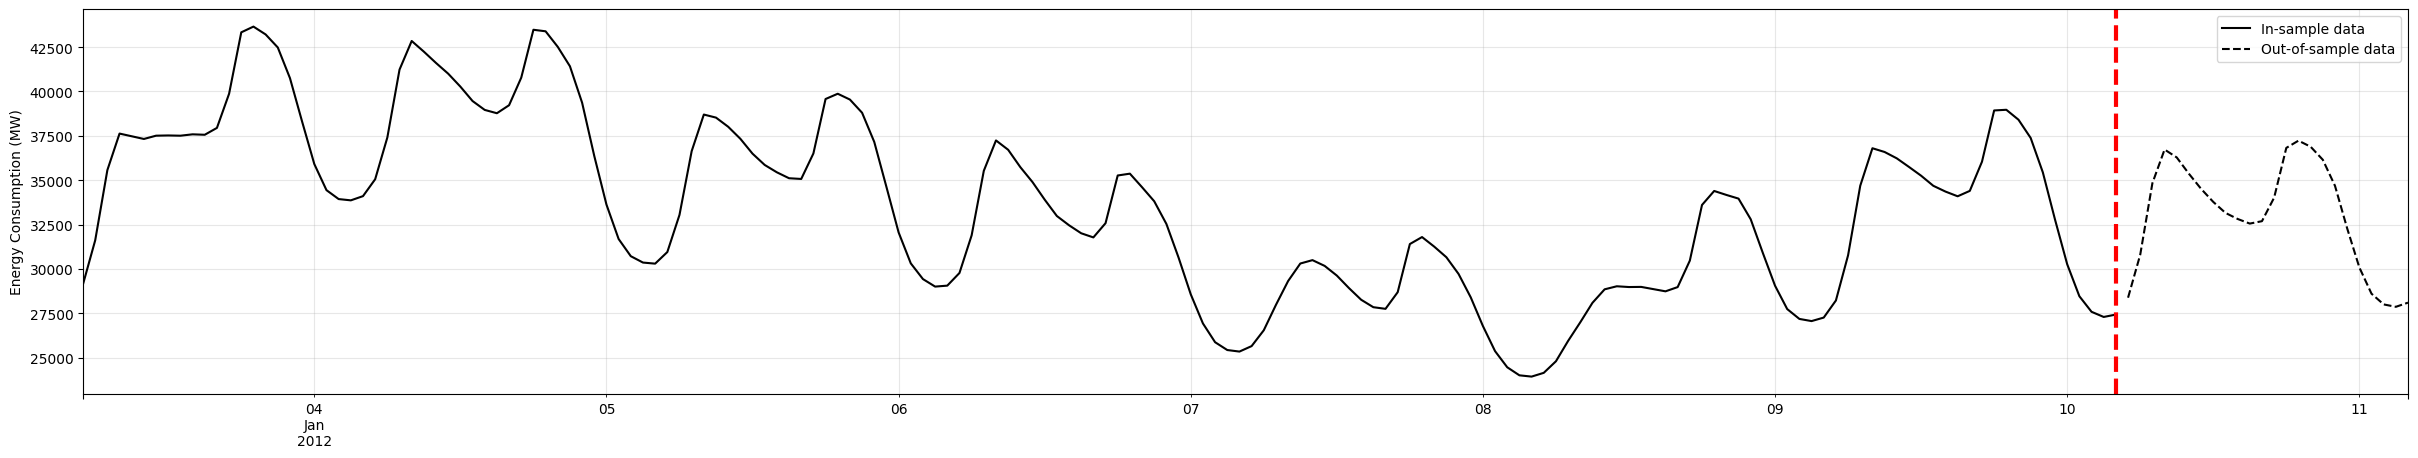

In [7]:
# plot both the in-sample and out-of-sample data
_, ax = plt.subplots(figsize=(30, 5))
df_current.plot(ax=ax, color="black", style="-")
df_future.plot(ax=ax, color="black", style="--")
ax.axvline(df_current.index[-1], color="red", lw=3, ls="--")
ax.set_ylabel("Energy Consumption (MW)")
ax.legend(("In-sample data", "Out-of-sample data"), loc="best", frameon=True)
ax.grid(which="both", alpha=0.3);

The original time series is non-stationary, so differencing was applied.



,diff
2012-01-03 06:00:00,2472.0
2012-01-03 07:00:00,3960.0
2012-01-03 08:00:00,2059.0
2012-01-03 09:00:00,-153.0
2012-01-03 10:00:00,-151.0
...,...
2012-01-10 00:00:00,-2518.0
2012-01-10 01:00:00,-1804.0
2012-01-10 02:00:00,-878.0
2012-01-10 03:00:00,-291.0


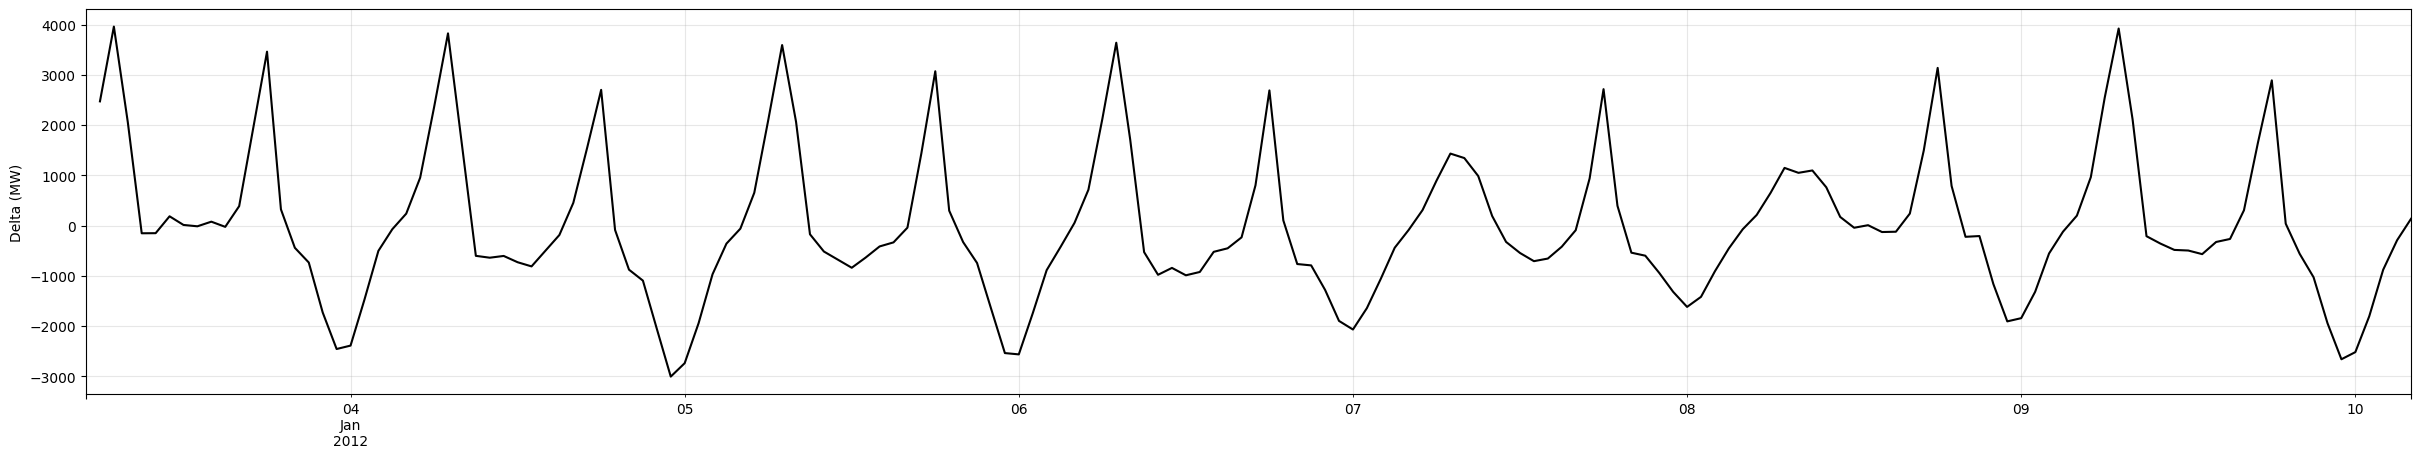

In [8]:
# specify the target
original_target: str = df_current.columns[0]

# ensure that the 'df_current' DataFrame contains a stationary time series
df_current: pd.DataFrame = ensure_stationarity(df_current, original_target)

# update the target, if necessary
target: str = "diff" if "diff" in df_current.columns else original_target

# determine if the original target is stationary or non-stationary
if original_target == target:
    print("The original time series is stationary.")
else:
    print("The original time series is non-stationary, so differencing was applied.\n")
    df_current[target].plot(figsize=(30, 5), color="black")
    plt.ylabel(f"Delta (MW)")
    plt.grid(which="both", alpha=0.3);
df_current[[target]].dropna()

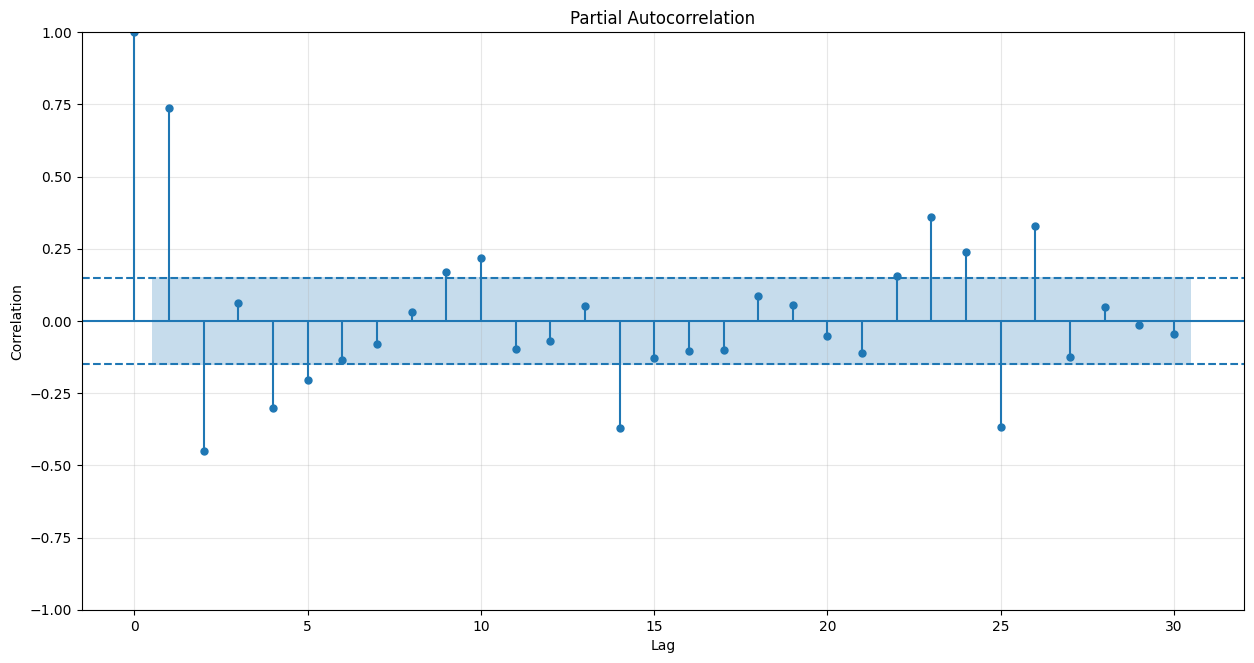

In [9]:
# partial autocorrelation plot of the target time series
_, ax = plt.subplots(figsize=(15, 7.5))
plot_pacf(df_current[target].dropna(), lags=30, method="ywmle", ax=ax)
ax.set_xlabel("Lag")
ax.set_ylabel("Correlation")
ax.axhline(0.15, ls="--")
ax.axhline(-0.15, ls="--")
ax.grid(which="both", alpha=0.3);

In [10]:
# get the maximum number of lags (based on the above plot)
lag_correlations: np.ndarray = pacf(df_current[target].dropna(), nlags=30, method="ywmle")
P: int = np.where(np.abs(lag_correlations) > 0.16)[0][-1]

# specify the maximum number of lags to create window features (hyperparameter)
max_window: int = 24

# convert the 1-D time series to an ML-ready tabular dataset
data: pd.DataFrame = create_model_inputs(df_current, target, P, max_window)

# output the 1st five rows of the 'data' DataFrame
data.head()

,hour,time_of_day,mean_window_4,std_window_4,mean_window_8,std_window_8,mean_window_12,std_window_12,mean_window_16,std_window_16,mean_window_20,std_window_20,mean_window_24,std_window_24,lag_26,lag_25,lag_24,lag_23,lag_22,lag_21,lag_20,lag_19,lag_18,lag_17,lag_16,lag_15,lag_14,lag_13,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,diff
2012-01-04 08:00:00,8,1,1842.75,1587.303032,367.000,2006.828059,-202.166667,1871.691837,229.5625,1899.694887,186.25,1690.360998,236.041667,1587.527569,2472.0,3960.0,2059.0,-153.0,-151.0,185.0,13.0,-14.0,78.0,-25.0,387.0,1928.0,3461.0,323.0,-442.0,-735.0,-1729.0,-2456.0,-2388.0,-1472.0,-503.0,-72.0,238.0,953.0,2355.0,3825.0,1615.0
2012-01-04 09:00:00,9,1,2187.00,1233.046093,867.375,1696.887482,-30.750000,1940.653691,306.3125,1931.027558,266.35,1719.425800,217.541667,1567.825162,3960.0,2059.0,-153.0,-151.0,185.0,13.0,-14.0,78.0,-25.0,387.0,1928.0,3461.0,323.0,-442.0,-735.0,-1729.0,-2456.0,-2388.0,-1472.0,-503.0,-72.0,238.0,953.0,2355.0,3825.0,1615.0,-602.0
2012-01-04 10:00:00,10,1,1798.25,1845.035388,976.125,1546.783061,-19.666667,1936.641626,148.1875,1892.584061,236.95,1729.469419,198.833333,1575.100954,2059.0,-153.0,-151.0,185.0,13.0,-14.0,78.0,-25.0,387.0,1928.0,3461.0,323.0,-442.0,-735.0,-1729.0,-2456.0,-2388.0,-1472.0,-503.0,-72.0,238.0,953.0,2355.0,3825.0,1615.0,-602.0,-639.0
2012-01-04 11:00:00,11,1,1049.75,2129.293682,959.125,1565.989914,71.166667,1873.720986,-108.0625,1679.730711,201.10,1740.334871,178.500000,1582.943708,-153.0,-151.0,185.0,13.0,-14.0,78.0,-25.0,387.0,1928.0,3461.0,323.0,-442.0,-735.0,-1729.0,-2456.0,-2388.0,-1472.0,-503.0,-72.0,238.0,953.0,2355.0,3825.0,1615.0,-602.0,-639.0,-604.0
2012-01-04 12:00:00,12,2,-57.50,1115.129439,892.625,1626.171396,225.500000,1716.301176,-166.0000,1679.858327,172.15,1749.087680,145.625000,1590.975550,-151.0,185.0,13.0,-14.0,78.0,-25.0,387.0,1928.0,3461.0,323.0,-442.0,-735.0,-1729.0,-2456.0,-2388.0,-1472.0,-503.0,-72.0,238.0,953.0,2355.0,3825.0,1615.0,-602.0,-639.0,-604.0,-729.0


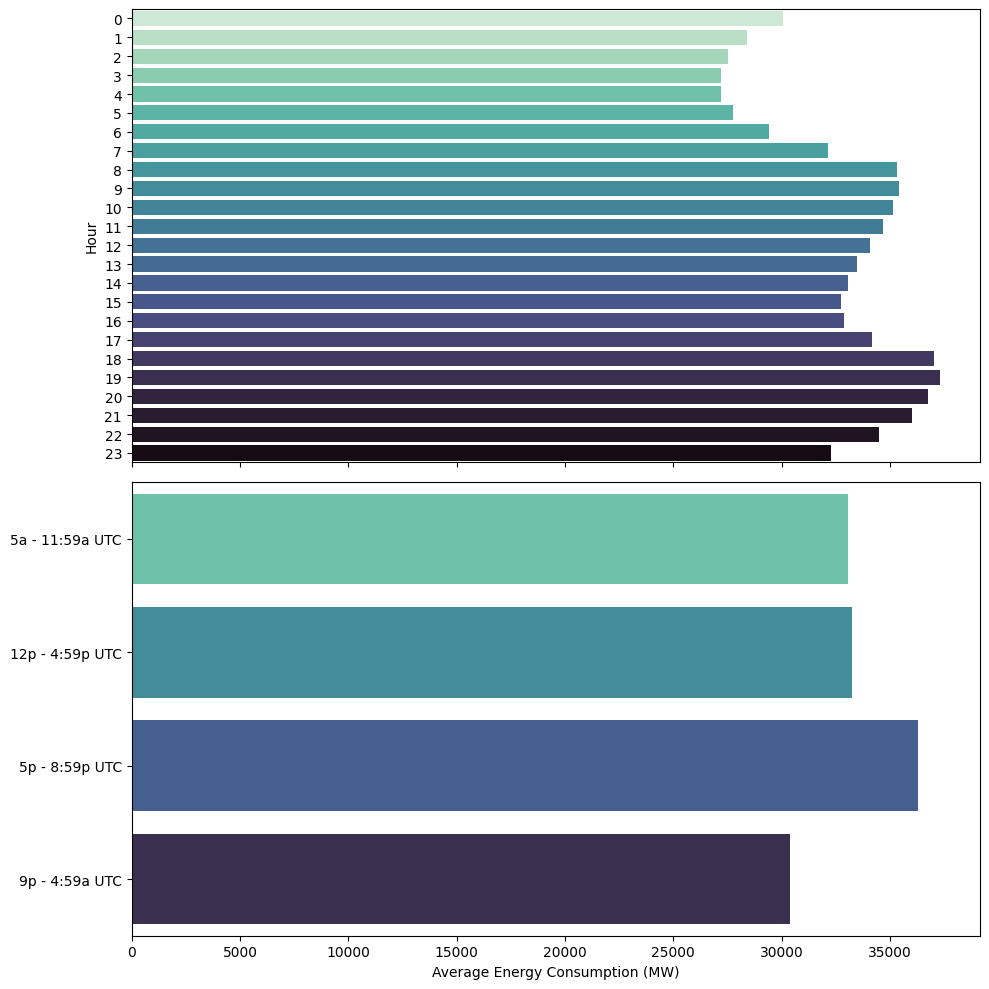

In [11]:
# bar plots of the average energy consumption per hour and per time of day
df_dt: pd.DataFrame = create_datetime_features(data)

_, ax = plt.subplots(df_dt.shape[1], figsize=(10, 5*df_dt.shape[1]), sharex=True)
for i, col in enumerate(df_dt.columns):
    df_temp: pd.DataFrame = (
        df_dt
        .assign(energy_consumption_mw=df_current.loc[df_dt.index, original_target])
        .groupby(col, as_index=False)
        [original_target]
        .mean()
    )
    if col == "time_of_day":
        df_temp[col] = df_temp[col].map({
            1: "5a - 11:59a UTC",
            2: "12p - 4:59p UTC",
            3: "5p - 8:59p UTC",
            4: "9p - 4:59a UTC"
        })
    sns.barplot(
        ax=ax[i],
        x=df_temp[original_target],
        y=df_temp[col],
        orient="h",
        palette="mako_r"
    )
    ax[i].set_xlabel("Average Energy Consumption (MW)")
    ax[i].set_ylabel(col.title() if col == "hour" else None)
plt.tight_layout();

**`Walk-forward validation`**

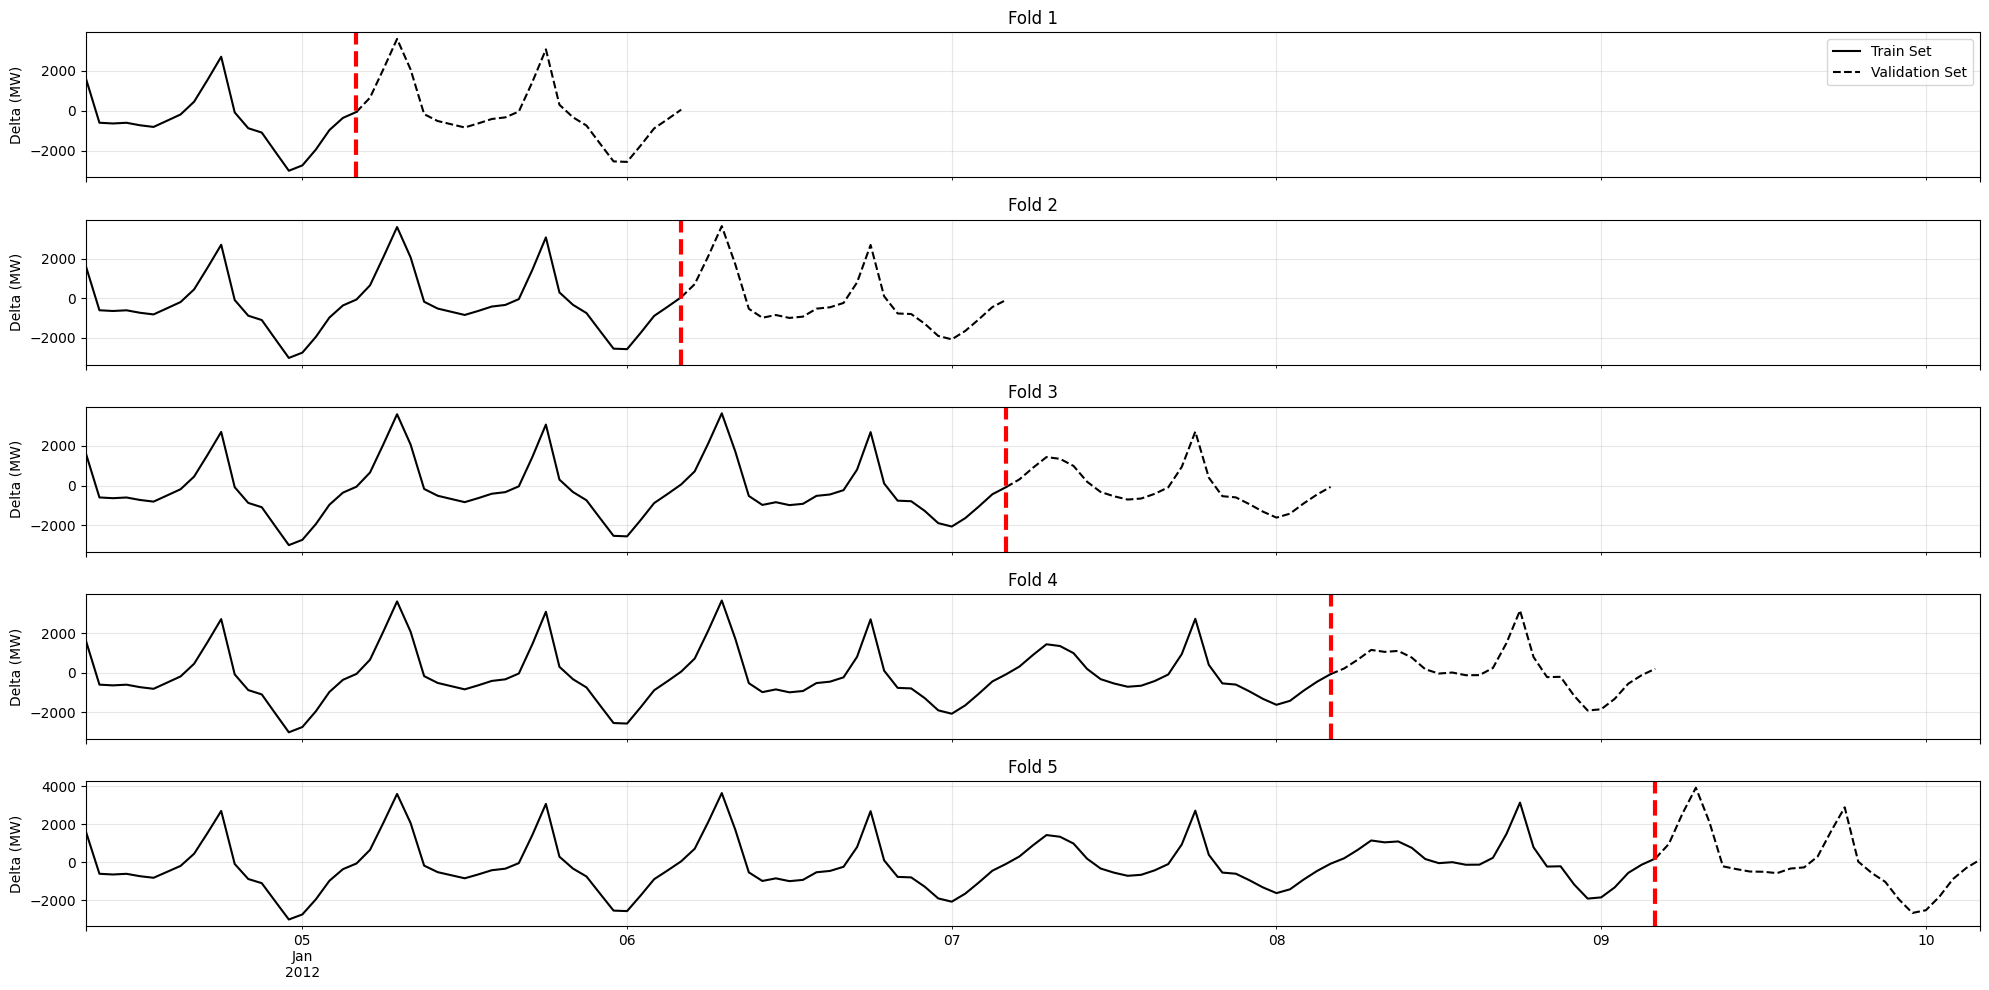

In [12]:
# get the ending index of each fold's train set
t_indices: List[int] = [data.shape[0] + (i*h) for i in np.arange(-10, 0)]

# get the ending index of each fold's validation set
v_indices: List[int] = [idx + h for idx in t_indices]

# a list of tuples ...
# where each tuple contains an index pair
idx_pairs: List[Tuple[int]] = [
    pair
    for pair in list(zip(t_indices, v_indices))
    if pair[0] > 0
]

# update the number of folds based on the 'idx_pairs' list
K: int = len(idx_pairs)

# plot the K-fold walk-forward validation
_, ax = plt.subplots(K, figsize=(20, 10), sharex=True)
for fold, (train_idx, val_idx) in enumerate(idx_pairs):
    y_label: str = "Delta (MW)" if target == "diff" else "Energy Usage (MW)"
    if fold == 0:
        train: pd.Series = data.iloc[:train_idx][target]
        val: pd.Series = data.iloc[train_idx - 1:val_idx][target]
        train.plot(ax=ax[fold], style="-", label="Train Set", color="black")
        val.plot(ax=ax[fold], style="--", label="Validation Set", color="black")
        ax[fold].axvline(val.index.min(), color="red", lw=3, ls="--")
        ax[fold].set_title(f"Fold {fold+1}")
        ax[fold].set_ylabel(y_label)
        ax[fold].grid(which="both", alpha=0.3)
        ax[fold].legend(loc="best", frameon=True)
    else:
        train: pd.Series = data.iloc[:train_idx][target]
        val: pd.Series = data.iloc[train_idx - 1:val_idx][target]
        train.plot(ax=ax[fold], style="-", label="Train Set", color="black")
        val.plot(ax=ax[fold], style="--", label="Validation Set", color="black")
        ax[fold].axvline(val.index.min(), color="red", lw=3, ls="--")
        ax[fold].set_title(f"Fold {fold+1}")
        ax[fold].set_ylabel(y_label)
        ax[fold].grid(which="both", alpha=0.3)
plt.tight_layout();

In [13]:
# perform walk-forward validation
xgb, forecast_metrics = walk_forward_validation(df_current, target, P, max_window, h)

[0]	validation_0-rmse:1348.16130	validation_1-rmse:1628.49523
[50]	validation_0-rmse:1347.22474	validation_1-rmse:1624.97911
[87]	validation_0-rmse:1347.22474	validation_1-rmse:1624.97911
[0]	validation_0-rmse:1325.30322	validation_1-rmse:1354.65333
[50]	validation_0-rmse:556.42169	validation_1-rmse:771.67633
[100]	validation_0-rmse:435.71371	validation_1-rmse:807.03860
[117]	validation_0-rmse:411.03811	validation_1-rmse:801.76522
[0]	validation_0-rmse:1283.33916	validation_1-rmse:1180.87376
[50]	validation_0-rmse:268.19399	validation_1-rmse:546.97274
[100]	validation_0-rmse:168.34083	validation_1-rmse:527.43197
[143]	validation_0-rmse:119.66196	validation_1-rmse:524.31102
[0]	validation_0-rmse:1211.02073	validation_1-rmse:828.23913
[50]	validation_0-rmse:164.58207	validation_1-rmse:673.49067
[57]	validation_0-rmse:143.72192	validation_1-rmse:654.61670
[0]	validation_0-rmse:1136.24711	validation_1-rmse:911.56419
[50]	validation_0-rmse:156.87565	validation_1-rmse:541.59272
[100]	validat

In [14]:
# for each fold, highlight the lag that produced the highest R²
forecast_metrics.style.highlight_max(color="green")

,fold_1,fold_2,fold_3,fold_4,fold_5
n_lags,,,,,
1,-1.557410,-23.280043,-4.728706,-43.787701,-0.317928
2,-1.557410,-23.280043,-1.023921,-42.790652,-10.770104
3,-1.421819,-16.466917,0.541260,-34.783648,-8.999759
4,-0.447141,-18.129727,-6.379133,-48.106739,-0.525983
5,-0.135957,-13.390097,-18.090122,-45.288726,-3.207306
6,-1.207294,-27.295799,-25.716222,-49.073518,-3.494144
7,-2.185220,-8.039755,-9.165251,-53.277219,-3.167459
8,-1.865756,-11.403750,-7.390756,-10.747447,-3.949015
9,-1.525225,-13.154133,-30.356332,-32.837268,-24.415046


**`Feature importance: Mutual Information Criterion`**

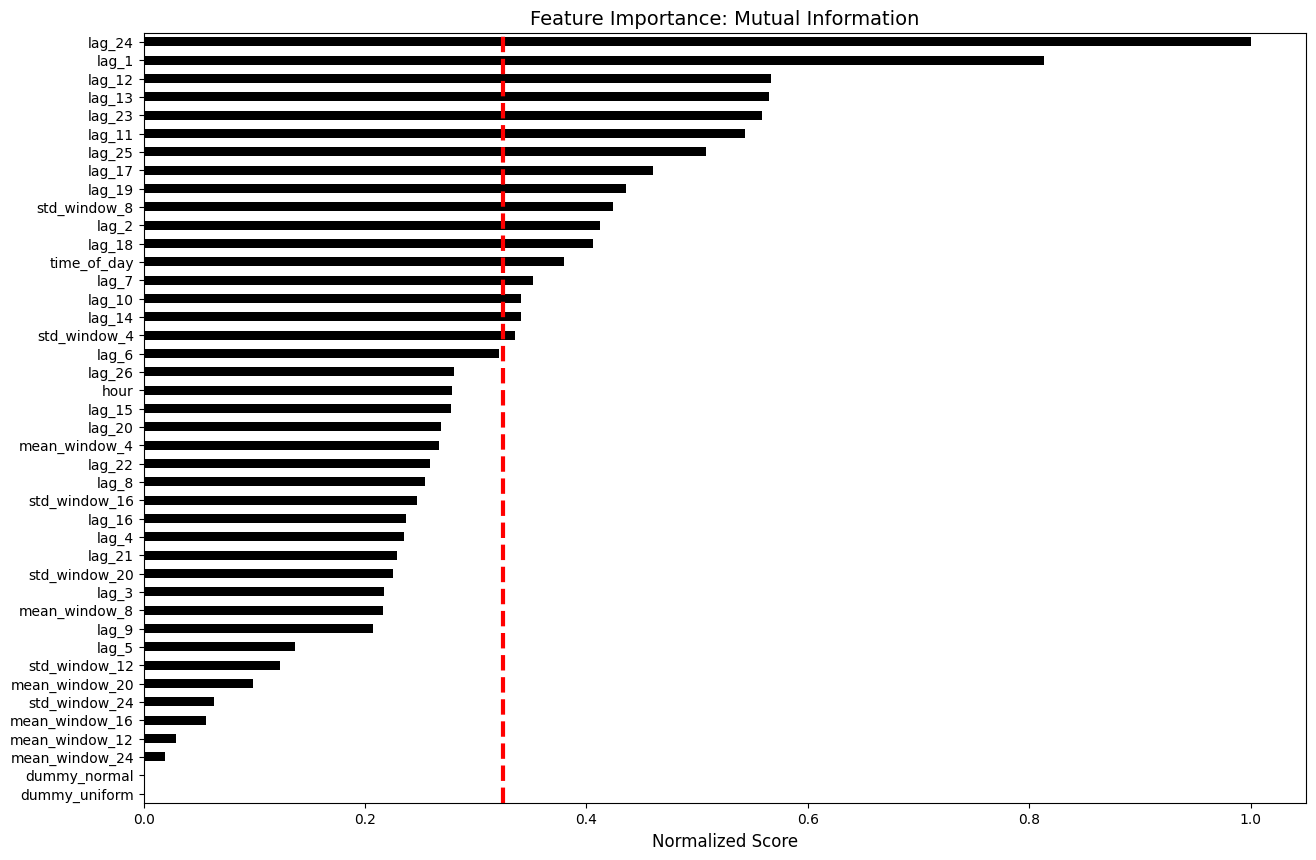

In [15]:
# create the model inputs
data: pd.DataFrame = create_model_inputs(df_current, target, P, max_window)

# add two 'dummy' features to the 'data' DataFrame
data = data.assign(
    dummy_normal=np.random.randn(data.shape[0]),
    dummy_uniform=np.random.uniform(low=0, high=1, size=data.shape[0])
)

# an empty dict to map each feature to its corresponding mutual info score
mi: Dict[str, float] = {}
for col in data.drop(target, axis=1).columns:
    score: float = mutual_info_regression(data[[col]], data[target])[0]
    mi[col] = score

# cast the 'mi' dict to a DataFrame and normalize the mutual info scores
mi: pd.DataFrame = (
    pd
    .DataFrame
    .from_dict(mi, orient="index", columns=["score"])
    .sort_values("score")
)
mi["score"] = mi["score"] / mi["score"].max()

# specify a threshold score to extract the 'relevant' features
threshold: float = mi.drop(["dummy_normal", "dummy_uniform"], axis=0)["score"].mean()

# get the 'relevant' features, that is, ...
# a list of features whose mutual info score > threshold score
rel_features: List[str] = [
    col
    for col in data.columns
    if col in sorted(mi.query(f"score > {threshold}").index, reverse=True)
]

# extract the matrix of 'relevant' features
X: pd.DataFrame = data[rel_features].copy(deep=True)

# get the corresponding target
y: pd.Series = df_current.loc[data.index, target]

# plot each feature's normalized mutual info score
_, ax = plt.subplots(figsize=(35, 5))
mi.plot(ax=ax, figsize=(15, 10), kind="barh", color="black", legend=None)
ax.axvline(threshold, color="red", lw=3, ls="--")
plt.title("Feature Importance: Mutual Information", fontsize=14)
plt.xlabel("Normalized Score", fontsize=12);

**`Hyperparameter tuning with walk-forward validation`**

In [16]:
# instantiate an object of type, 'TimeSeriesSplit'
tss: TimeSeriesSplit = TimeSeriesSplit(
    n_splits=K,
    test_size=h,
    gap=0
)

# create the hyperparameter search space
search_space: Dict[str, List[Union[int, float]]] = {
    "n_estimators": [100, 200, 1000], 
    "max_depth": [3, 6, 15],
    "learning_rate": [0.1, 0.3, 0.5],
    "gamma": [0, 0.1, 1]
}

# instantiate an object of type, 'GridSearchCV'
xgb.n_estimators = 100
xgb.early_stopping_rounds = None
gs: GridSearchCV = GridSearchCV(
    estimator=xgb,
    param_grid=search_space,
    scoring="r2",
    refit="r2",
    cv=tss,
    verbose=4
)

# fit the 'gs' object
gs.fit(X.values, y.values)

# assign the 'best' model to the variable, 'xgb_tuned'
xgb_tuned: XGBRegressor = gs.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100;, score=-0.094 total time=   0.0s
[CV 2/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.715 total time=   0.0s
[CV 3/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.478 total time=   0.0s
[CV 4/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.901 total time=   0.0s
[CV 5/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.778 total time=   0.1s
[CV 1/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200;, score=-0.094 total time=   0.1s
[CV 2/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.736 total time=   0.0s
[CV 3/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.467 total time=   0.0s
[CV 4/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.908 total time=   0.1s


**`Predict the future`**

In [17]:
# instantiate an Auto ARIMA model and fit it to the in-sample data
arima_model: pm.ARIMA = pm.auto_arima(
    df_current[original_target],
    stationary=True if original_target == target else False,
    seasonal=False,
    max_p=P,
    m=1,
    trace=False,
    suppress_warnings=True,
)

# get the ARIMA model's forecast (this serves as the baseline forecast)
arima_forecast: np.ndarray = arima_model.predict(n_periods=h, return_conf_int=False).values

# get the XGBoost model's recursive forecast
xgb_forecast: np.ndarray = predict_future(
        xgb_tuned,
        df_current,
        rel_features,
        target,
        P,
        max_window,
        df_future.index
    )
assert df_future.shape[0] == xgb_forecast.shape[0]

# add the Naive, ARIMA, and XGBoost forecasts to the 'df_future' DataFrame
df_future = df_future.assign(
    naive=df_current.iloc[-1][original_target]*np.ones(df_future.shape[0]),
    arima=arima_forecast, 
    xgboost=xgb_forecast
)

**`Plot and evaluate each forecast`**

In [18]:
# output the R² for each forecast
model_to_metric: Dict[str, float] = {}
for col in df_future.drop(original_target, axis=1).columns:
    metric: float = get_rsquared(df_future[original_target], df_future[col])
    model_to_metric[col] = round(metric, 2)
model_to_metric

{'naive': -3.3, 'arima': -1.98, 'xgboost': 0.94}

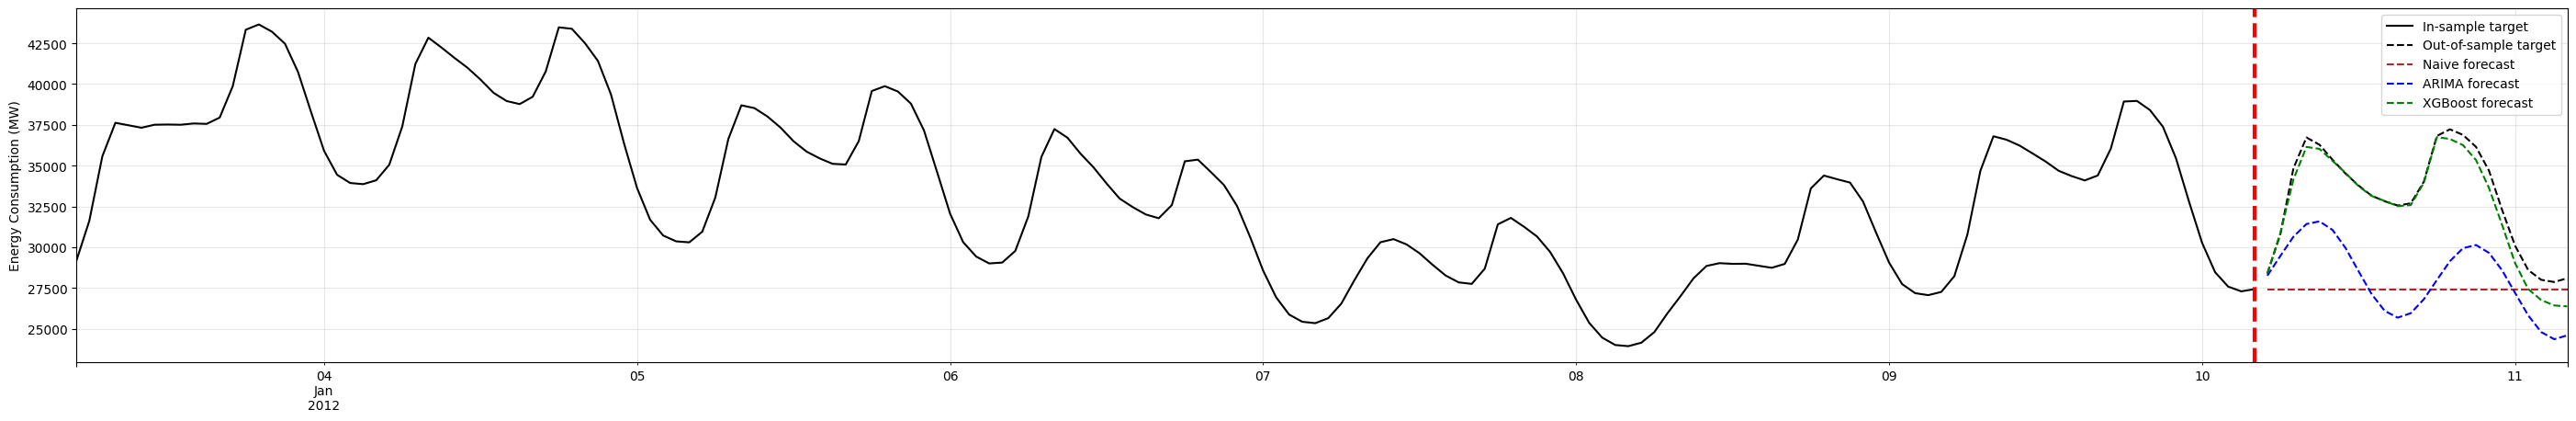

In [19]:
# plot the in-sample target, out-of-sample target, and each model's forecast
col: str = sorted(model_to_metric.items(), key=lambda x: x[1], reverse=True)[0][0]
_, ax = plt.subplots(figsize=(35, 5))
df_current[original_target].plot(ax=ax, color="black", style="-")
df_future.plot(
    ax=ax,
    color=["black", "brown", "blue", "green",],
    style=["--", "--", "--", "--"]
)
ax.axvline(df_current.index[-1], color="red", lw=3, ls="--")
# ax.axhline(df_current[original_target].max(), color="red", lw=3, ls="--")
ax.set_ylabel("Energy Consumption (MW)")
ax.legend(
    (
        "In-sample target",
        "Out-of-sample target",
        "Naive forecast",
        "ARIMA forecast",
        "XGBoost forecast"
    ),
    loc="best",
    frameon=True
)
ax.grid(which="both", alpha=0.3);